In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

In [ ]:
! pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
! pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
! pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
! pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
! pip install torch-geometric
! pip install torch-geometric-temporal

In [ ]:
from datetime import datetime
import geopy.distance
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import STConv
from tqdm import tqdm

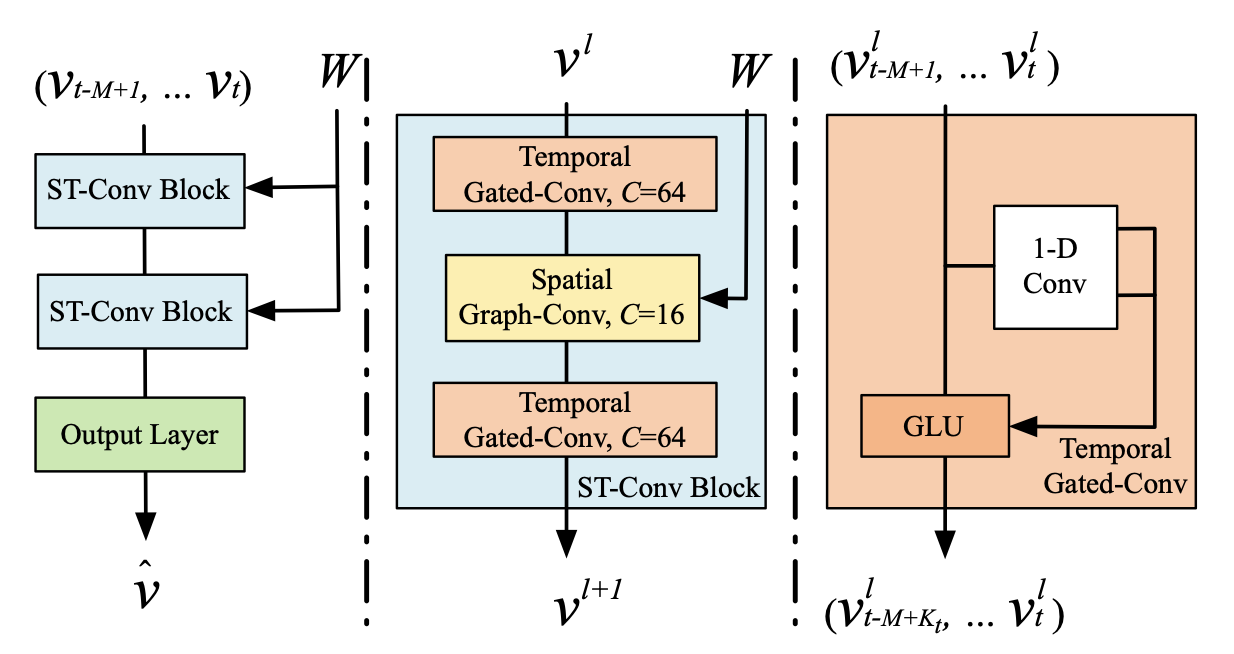

In [ ]:
class FullyConnLayer(nn.Module):
    def __init__(self, c):
        super(FullyConnLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation = 1, padding = (0,0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation = 1, padding = (0,0))
        self.fc = FullyConnLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)

        return self.fc(x_t2)
# final model
# a specified number of STConv blocks, followed by an output layer
class TrafficModel(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers,
                 kernel_size, K, window_size, \
                 normalization = 'sym', bias = True):
    # num_nodes = number of nodes in the input graph
    # channel_size_list =  2d array representing feature dimensions throughout the model
    # num_layers = number of STConv blocks
    # kernel_size = length of the temporal kernel
    # K = size of the chebyshev filter for the spatial convolution
    # window_size = number of historical time steps to consider
        super(TrafficModel, self).__init__()
        self.layers = nn.ModuleList([])
        for l in range(num_layers):
            input_size, hidden_size, output_size = \
            channel_size_list[l][0], channel_size_list[l][1], \
            channel_size_list[l][2]
            self.layers.append(STConv(num_nodes, input_size, hidden_size, \
                                      output_size, kernel_size, K, \
                                      normalization, bias))
        # add output layer
        self.layers.append(OutputLayer(channel_size_list[-1][-1], \
                                       window_size - 2 * num_layers * (kernel_size - 1), \
                                       num_nodes))
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight):
        for layer in self.layers[:-1]:
          x = layer(x, edge_index, edge_weight)
        out_layer = self.layers[-1]
        x = x.permute(0, 3, 1, 2)
        x = out_layer(x)
        return x

In [ ]:
directory = r'C:\Users\srush\Downloads\IE434'
filename = "best_model.pt"

In [ ]:
# model parameters
channels = np.array([[1, 4, 8], [8, 4, 8]]) # sequence of channel sizes

kernel_size = 3 # size of temporal kernel
K = 3 # chebyshev filter size

learning_rate = 0.01
batch_size = 10
num_epochs = 20
num_layers = 1 # number of STConv blocks
n_his = 20 # number of historical time steps to consider
n_pred = 5 # steps in the future we want to predict

train_prop = 0.7
val_prop = 0.2
test_prop = 0.1

model_save_path = os.path.join(directory, filename)

In [ ]:
def data_transform(data, n_his, n_pred, device):
    # data = slice of V matrix
    # n_his = number of historical speed observations to consider
    # n_pred = number of time steps in the future to predict

    num_nodes = data.shape[1]
    num_obs = len(data) - n_his - n_pred
    x = np.zeros([num_obs, n_his, num_nodes, 1])
    y = np.zeros([num_obs, num_nodes])

    obs_idx = 0
    for i in range(num_obs):
        head = i
        tail = i + n_his
        x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        y[obs_idx] = data[tail + n_pred - 1]
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [ ]:
weighted_adj_matrix_path = os.path.join('distances23.csv')
W = pd.read_csv(weighted_adj_matrix_path).drop('station_id', axis=1)

feature_vectors_path = os.path.join('combined23.csv')
V = pd.read_csv(feature_vectors_path).drop('time', axis=1)

In [ ]:
W.head()

,3710.07,3803.05,3847.04,3893.03,3911.05,3914.02,4039.04,4060.09,4089.01,4128.08,...,JC105,JC106,JC107,JC108,JC109,JC110,JC115,JC116,SYS035,SYS038
0,0.000000,3735.909490,4044.191485,5334.174887,4283.650619,3273.792341,5400.028207,2800.537728,733.953657,3257.122298,...,6756.409922,4703.925514,8424.340084,8887.862719,7786.636899,5985.541425,5612.101027,4803.073066,4088.159651,4410.369141
1,3735.909490,0.000000,2261.627105,4380.117625,2996.340172,463.538969,4956.976409,4961.036501,4399.258179,5345.993669,...,9247.962751,6895.899947,9361.393782,9654.985268,9805.836276,7692.970602,7646.815547,6929.440653,7276.715429,6621.660228
2,4044.191485,2261.627105,0.000000,2119.221570,743.918042,2268.323288,2713.752228,6255.086729,4774.905677,6702.951679,...,10549.190960,8287.726917,11284.747092,11630.565725,11346.397238,9316.170007,9133.527965,8352.167674,8103.462166,5152.972985
3,5334.174887,4380.117625,2119.221570,0.000000,1402.175972,4372.012434,777.554136,7918.079936,5998.891837,8381.758720,...,12080.340604,9933.425027,13215.412886,13591.396120,13027.977386,11083.075339,10818.211787,10015.409656,9378.196574,4507.882536
4,4283.650619,2996.340172,743.918042,1402.175972,0.000000,2970.640863,1969.872709,6694.817851,4994.586755,7152.372200,...,10939.306354,8725.998673,11872.306690,12235.195466,11807.816723,9816.095108,9592.638982,8799.078616,8371.809616,4689.007955


In [ ]:
V.head()

,3710.07,3803.05,3847.04,3893.03,3911.05,3914.02,4039.04,4060.09,4089.01,4128.08,...,JC105,JC106,JC107,JC108,JC109,JC110,JC115,JC116,SYS035,SYS038
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,2,2,0,0,2,0,0,0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,1,0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,1,0,6,0,0.0,0.0


In [ ]:
for pos, col in enumerate(W.columns):
  if col != V.columns[pos]:
    print(col, V.columns[pos])

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")

In [ ]:
# get graph attributes
num_samples, num_nodes = V.shape

# get splits of V matrix
len_train = round(num_samples * train_prop)
len_val = round(num_samples * val_prop)
train = V[ : len_train]
val = V[len_train : len_train + len_val]
test = V[len_train + len_val : len_train + len_val + round(num_samples * test_prop)]

# normalize values
scaler = StandardScaler()
train = np.nan_to_num(scaler.fit_transform(train))
val = np.nan_to_num(scaler.transform(val))
test = np.nan_to_num(scaler.transform(test))

# create training examples using helper function
x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

# create torch data iterables for training
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

# format graph for pyg layer inputs
G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

In [ ]:
model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def evaluate_model(model, loss, data_iter, edge_index, edge_weight, device):
  model.eval()
  l_sum, n = 0.0, 0
  with torch.no_grad():
      for x, y in data_iter:
          y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
          l = loss(y_pred, y)
          l_sum += l.item() * y.shape[0]
          n += y.shape[0]
      return l_sum / n

def evaluate_metric(model, data_iter, scaler, edge_index, edge_weight, device):
    model.eval()
    epsilon = 1e-6
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x.to(device), \
                                                    edge_index, \
                                                    edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / (y+epsilon)).tolist()
            mse += (d ** 2).tolist()
        MAE = np.array(mae).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, RMSE


In [ ]:
min_val_loss = np.inf
for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  l_sum, n = 0.0, 0

  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):

    y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
    l = loss(y_pred, y)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    l_sum += l.item() * y.shape[0]
    n += y.shape[0]

  #validation loss
  val_loss = evaluate_model(model, loss, val_iter, edge_index, edge_weight, device)
  if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model.state_dict(), model_save_path)
  print("epoch", epoch, ", train loss:", l_sum / n, ", validation loss:", val_loss)

Epoch:   5%|▌         | 1/20 [1:33:40<29:39:52, 5620.67s/it]

epoch 1 , train loss: 0.7461039492031702 , validation loss: 0.8171095047465227


Epoch:  10%|█         | 2/20 [3:09:56<28:33:37, 5712.07s/it]

epoch 2 , train loss: 0.7300933131240387 , validation loss: 0.8048834529925846


Epoch:  15%|█▌        | 3/20 [4:45:31<27:01:22, 5722.52s/it]

epoch 3 , train loss: 0.7250779459526454 , validation loss: 0.7944481395695625


Epoch:  20%|██        | 4/20 [6:23:53<25:44:53, 5793.34s/it]

epoch 4 , train loss: 0.7221730385988592 , validation loss: 0.8122500109745949


Epoch:  25%|██▌       | 5/20 [7:59:18<24:02:08, 5768.54s/it]

epoch 5 , train loss: 0.7205606492087262 , validation loss: 0.79856503560466


Epoch:  30%|███       | 6/20 [9:35:35<22:26:41, 5771.55s/it]

epoch 6 , train loss: 0.719402633150524 , validation loss: 0.7991742500411549


Epoch:  35%|███▌      | 7/20 [11:11:52<20:50:53, 5773.38s/it]

epoch 7 , train loss: 0.7181835188826214 , validation loss: 0.7882922082788361


Epoch:  40%|████      | 8/20 [12:48:52<19:17:36, 5788.05s/it]

epoch 8 , train loss: 0.716897050699349 , validation loss: 0.79870169461963


Epoch:  45%|████▌     | 9/20 [14:03:19<16:25:26, 5375.15s/it]

epoch 9 , train loss: 0.7162111400496023 , validation loss: 0.796628645120763


Epoch:  50%|█████     | 10/20 [14:56:27<13:03:19, 4699.93s/it]

epoch 10 , train loss: 0.7156313793206265 , validation loss: 0.7861746127783927


Epoch:  55%|█████▌    | 11/20 [15:48:56<10:33:46, 4225.18s/it]

epoch 11 , train loss: 0.714750463167069 , validation loss: 0.7947539952699664


Epoch:  60%|██████    | 12/20 [16:49:54<9:00:23, 4052.90s/it] 

epoch 12 , train loss: 0.7146412094197028 , validation loss: 0.7901862998358105


Epoch:  65%|██████▌   | 13/20 [18:23:31<8:48:06, 4526.58s/it]

epoch 13 , train loss: 0.714448729216552 , validation loss: 0.784579510462537


Epoch:  70%|███████   | 14/20 [19:58:16<8:07:38, 4876.43s/it]

epoch 14 , train loss: 0.7140926332830883 , validation loss: 0.7890859891013517


Epoch:  75%|███████▌  | 15/20 [21:31:29<7:04:21, 5092.37s/it]

epoch 15 , train loss: 0.7135892535013243 , validation loss: 0.7853899128296966


Epoch:  80%|████████  | 16/20 [22:57:24<5:40:45, 5111.42s/it]

epoch 16 , train loss: 0.713235175583 , validation loss: 0.7908613990855946


Epoch:  85%|████████▌ | 17/20 [23:50:47<3:46:52, 4537.40s/it]

epoch 17 , train loss: 0.713004300820679 , validation loss: 0.7934184087892977


Epoch:  90%|█████████ | 18/20 [24:43:48<2:17:39, 4129.76s/it]

epoch 18 , train loss: 0.7130243565500114 , validation loss: 0.7864572874841939


Epoch:  95%|█████████▌| 19/20 [25:37:03<1:04:09, 3849.22s/it]

epoch 19 , train loss: 0.7124830419388039 , validation loss: 0.7924174306938871


Epoch: 100%|██████████| 20/20 [26:29:42<00:00, 4769.15s/it]  

epoch 20 , train loss: 0.7125720986665289 , validation loss: 0.7868904289891044


In [ ]:
#model with least validation loss
best_model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, \
                     n_his, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

#evaluating on test set
l = evaluate_model(best_model, loss, test_iter, edge_index, edge_weight, device)

In [ ]:
MAE, RMSE = evaluate_metric(best_model, test_iter, scaler, edge_index, edge_weight, device)
print("test loss:", l, "\nMAE:", MAE, ", RMSE:", RMSE)

test loss: 1.0052724266139004 
MAE: 0.19932702001218466 , RMSE: 0.769187343584428


In [ ]:
predict_model = best_model

pred_save_path = os.path.join(directory, 'predictions_testing.csv')

In [ ]:
def get_predictions(model, pred_iter, scaler, edge_index, edge_weight, num_nodes, device):
    model.eval()
    with torch.no_grad():
      for x, y in pred_iter:
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
        y_pred = scaler.inverse_transform(model(x.to(device), \
                                                edge_index, \
                                                edge_weight).view(len(x), -1).cpu().numpy()).reshape(-1)
        y_pred = y_pred.reshape(-1, num_nodes)

      return y, y_pred

In [ ]:
# create prediction set
pred_len = 144 #last 3 days

pred_set = V[(-pred_len - n_his - n_pred):]
pred_set = np.nan_to_num(scaler.transform(pred_set))
x_pred, y_pred = data_transform(pred_set, n_his, n_pred, device)
pred_data = torch.utils.data.TensorDataset(x_pred, y_pred)
pred_iter = torch.utils.data.DataLoader(pred_data, pred_len + n_his + n_pred + 1)

predictions = get_predictions(predict_model, pred_iter, scaler, edge_index, edge_weight, 498, device)
np.savetxt(pred_save_path, predictions[1], delimiter=',')

In [ ]:
predictions

(array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.9281538e-08, -2.9244925e-12, -2.9244925e-12], dtype=float32),
 array([[-4.9540251e-03, -3.0808300e-03,  4.0816218e-03, ...,
          1.1483927e+00,  2.8109268e-04,  4.7154030e-05],
        [-5.2413642e-03, -4.1163266e-03,  3.8534105e-03, ...,
          1.0234003e+00,  2.7405174e-04,  5.1362324e-05],
        [-5.7957470e-03, -4.7506094e-03,  3.8668886e-03, ...,
          6.1705381e-01,  2.6197484e-04,  6.2608815e-05],
        ...,
        [-6.8276301e-03, -7.7208579e-03,  2.6376322e-03, ...,
          7.7889067e-01,  2.3911172e-04,  5.1470164e-05],
        [-6.8605915e-03, -7.8579187e-03,  2.5634915e-03, ...,
          4.5286533e-01,  2.3509134e-04,  5.8967093e-05],
        [-7.0048347e-03, -7.7977777e-03,  2.9728189e-03, ...,
          3.7155995e-01,  2.3567630e-04,  6.3364409e-05]], dtype=float32))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [ ]:
test_truth

,3710.07,3803.05,3847.04,3893.03,3911.05,3914.02,4039.04,4060.09,4089.01,4128.08,...,JC105,JC106,JC107,JC108,JC109,JC110,JC115,JC116,SYS035,SYS038
12819,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,2,0,0.0,0.0
12820,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,2,2,0,0,0.0,0.0
12821,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,2,0,0,0,0,1,4,0,0.0,0.0
12822,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,5,0,0.0,0.0
12823,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,0,1,0,5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12958,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,8,0,0,2,0.0,0.0
12959,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,5,0,0,0,3,2,0,1,0.0,0.0
12960,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,5,3,0,0,0.0,0.0
12961,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,3,0,0,2,0.0,0.0


In [ ]:
test_preds

,0,1,2,3,4,5,6,7,8,9,...,488,489,490,491,492,493,494,495,496,497
0,-0.004954,-0.003081,0.004082,0.005454,0.004892,-0.005088,0.005722,0.000565,-0.004813,-0.004141,...,1.191836,0.008065,0.033167,0.123601,1.095118,0.919748,5.087221,1.148393,0.000281,0.000047
1,-0.005241,-0.004116,0.003853,0.005399,0.004778,-0.005367,0.005701,0.000470,-0.005141,-0.004950,...,0.934918,-0.020411,0.031205,0.108055,1.075499,0.736078,4.275944,1.023400,0.000274,0.000051
2,-0.005796,-0.004751,0.003867,0.005479,0.004860,-0.005796,0.005811,0.000539,-0.005687,-0.005651,...,0.720724,0.001800,0.030735,0.094312,0.958615,0.559440,3.105599,0.617054,0.000262,0.000063
3,-0.006616,-0.005489,0.003695,0.005265,0.004696,-0.006232,0.005611,0.000573,-0.006498,-0.006311,...,0.647168,0.051774,0.033326,0.085974,0.875082,0.446404,2.488459,0.402941,0.000247,0.000075
4,-0.007130,-0.006429,0.002978,0.004394,0.003929,-0.006871,0.004733,0.000439,-0.006935,-0.006947,...,0.530809,0.027171,0.029441,0.073761,0.712582,0.285895,1.742072,0.137776,0.000230,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.006830,-0.007104,0.003131,0.004548,0.004090,-0.006103,0.004891,0.000477,-0.006765,-0.006886,...,1.590453,0.002766,0.069222,0.111334,1.618753,1.075994,1.013451,1.091781,0.000247,0.000036
140,-0.006769,-0.007721,0.002707,0.004059,0.003653,-0.006576,0.004405,0.000497,-0.006609,-0.007087,...,1.712653,-0.039471,0.076149,0.116109,1.631464,1.283823,0.942312,1.152465,0.000247,0.000041
141,-0.006828,-0.007721,0.002638,0.003994,0.003585,-0.006546,0.004338,0.000363,-0.006649,-0.007056,...,1.310628,-0.026737,0.066533,0.095638,1.075649,0.843327,0.759070,0.778891,0.000239,0.000051
142,-0.006861,-0.007858,0.002563,0.003903,0.003511,-0.006628,0.004251,0.000285,-0.006670,-0.007093,...,0.910173,-0.041499,0.058943,0.086297,0.850938,0.673638,0.519362,0.452865,0.000235,0.000059


In [ ]:
original_scale_preds = scaler.inverse_transform(test_preds)
original_scale_preds

array([[-4.95402515e-03, -3.08082998e-03,  4.08162177e-03, ...,
         3.83066013e+00,  1.13131079e-04,  1.10675631e-04],
       [-5.24136424e-03, -4.11632657e-03,  3.85341048e-03, ...,
         3.55246438e+00,  1.13057177e-04,  1.10719802e-04],
       [-5.79574704e-03, -4.75060940e-03,  3.86688858e-03, ...,
         2.64805825e+00,  1.12930416e-04,  1.10837846e-04],
       ...,
       [-6.82763010e-03, -7.72085786e-03,  2.63763219e-03, ...,
         3.00825884e+00,  1.12690442e-04,  1.10720933e-04],
       [-6.86059147e-03, -7.85791874e-03,  2.56349146e-03, ...,
         2.28262366e+00,  1.12648244e-04,  1.10799622e-04],
       [-7.00483471e-03, -7.79777765e-03,  2.97281891e-03, ...,
         2.10166212e+00,  1.12654383e-04,  1.10845777e-04]])

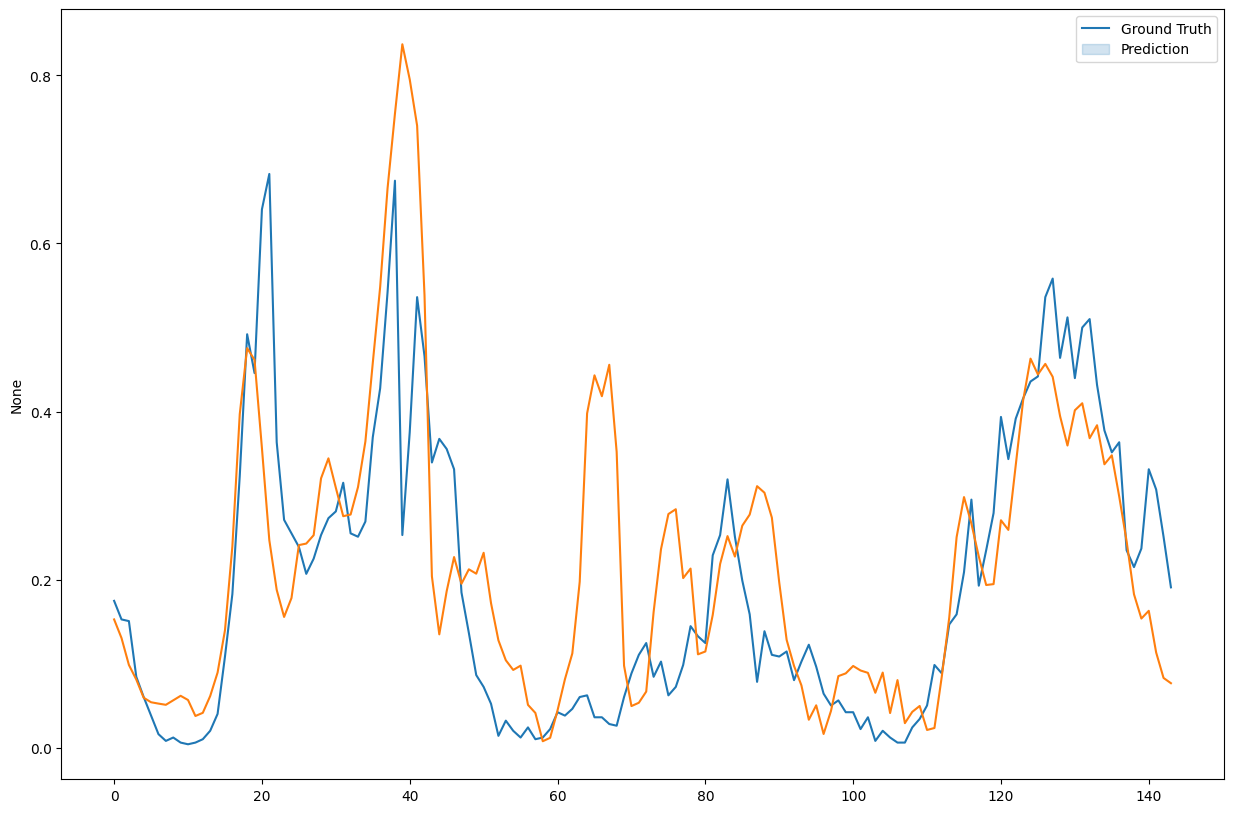

In [ ]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.lineplot(y=summed_test_truth, x=range(len(summed_test_preds)))
sns.lineplot(y=summed_test_preds, x=range(len(summed_test_preds)))
plt.legend(labels=['Ground Truth', 'Prediction']);

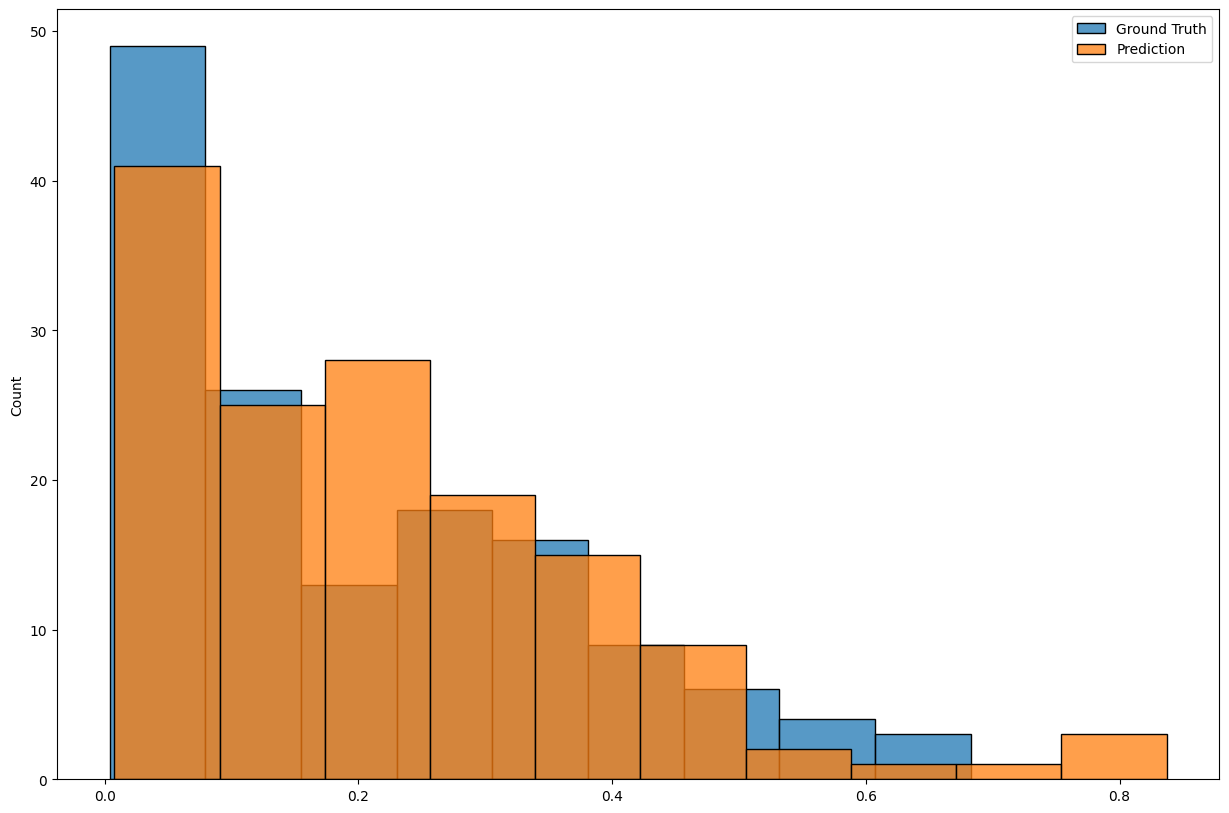

In [ ]:

test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=1)
summed_test_preds = test_preds.mean(axis=1)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);

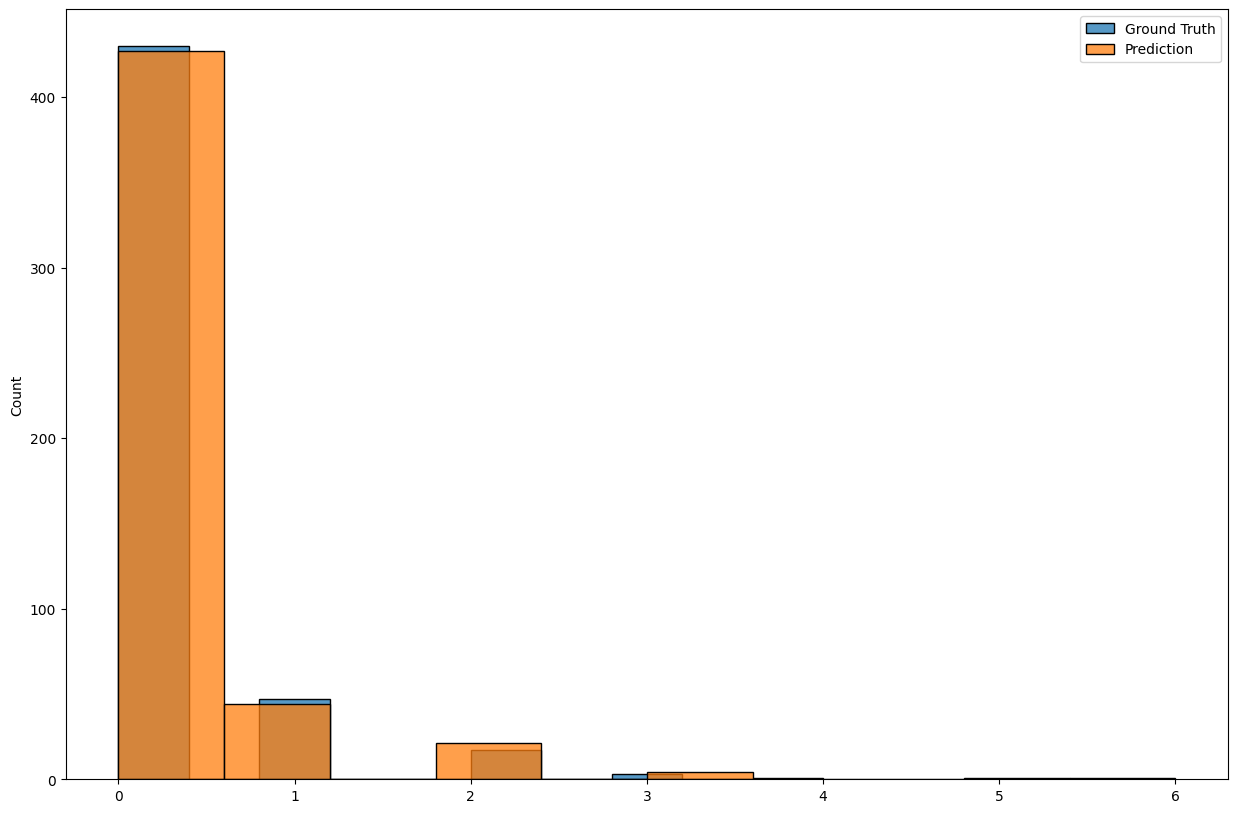

In [ ]:
test_preds = pd.read_csv(pred_save_path, header=None)
test_truth = V[(-pred_len-2):-2]
summed_test_truth  = test_truth.mean(axis=0).round(decimals=0)
summed_test_preds = test_preds.mean(axis=0).round(decimals=0)
sns.histplot(summed_test_truth)
sns.histplot(summed_test_preds, color=sns.color_palette()[1])
plt.legend(labels=['Ground Truth', 'Prediction']);